# Initial Application of GBDT for Fuel Price Imputation
Notes for future work:
* the immediate next step should be to implement a better cross validation process. The current one (random row sampling) encourages overfitting due to leakage/autocorrelation between samples at the same plant. Latitude and Longitude probably shouldn't work as well as they do right now.
    * examine missing fuel costs to see how they are distributed (are the same plants missing every time? Is the missingness constant in time? etc)
    * design a CV process that emulates that as best as possible, like maybe selecting random whole plants via GroupShuffleSplit or something
* consider our objectives: do we want a weighted fuel price or raw prices?
* then do feature engineering/selection
* could look at fuel costs/quantities from FERC Form 1 for comparision. They give annual figures. Could use for aggregate validation.
* reverse engineer the EIA API and see if they include redacted data. Could use that for ultimate validation.

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import pathlib
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgbm
from pandas_profiling import ProfileReport
import sqlalchemy as sa

# Local libraries
import pudl

# Notebook Parameters

In [5]:
sns.set()
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,4)
#mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [6]:
pudl_settings = pudl.workspace.setup.get_defaults()
display(pudl_settings)

pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
display(pudl_engine)

{'pudl_in': '/home/tpb/catalyst/workspace',
 'data_dir': '/home/tpb/catalyst/workspace/data',
 'settings_dir': '/home/tpb/catalyst/workspace/settings',
 'pudl_out': '/home/tpb/catalyst/workspace',
 'sqlite_dir': '/home/tpb/catalyst/workspace/sqlite',
 'parquet_dir': '/home/tpb/catalyst/workspace/parquet',
 'ferc1_db': 'sqlite:////home/tpb/catalyst/workspace/sqlite/ferc1.sqlite',
 'pudl_db': 'sqlite:////home/tpb/catalyst/workspace/sqlite/pudl.sqlite',
 'censusdp1tract_db': 'sqlite:////home/tpb/catalyst/workspace/sqlite/censusdp1tract.sqlite'}

Engine(sqlite:////home/tpb/catalyst/workspace/sqlite/pudl.sqlite)

In [9]:
assert os.environ["API_KEY_EIA"]

# Load Data
* Given the above parameters and functions, it should now be possible to load the required data into local variables for further wrangling, analysis, and visualization.
* If the data is not yet present on the machine of the person running the notebook, this step should also acquire the data from its original source, and place it in the appropriate location under `<PUDL_IN>/data/local/`.
* If there are steps which have to be done manually here, put them first so that they fail first if the user hasn't read the instructions, and they can fix the situation before a bunch of other work gets done. Try to minimize the amount of work in the filesystem that has to be done manually though.
* If this process takes a little while, don't be shy about producing `logging` output.
* Using the `%%time` cell magic can also help users understand which pieces of work / data acquisition are hard:

In [10]:
%%time
pudl_out = pudl.output.pudltabl.PudlTabl(
    freq=None,
    start_date=None,
    end_date=None,
    pudl_engine=pudl_engine,
    fill_fuel_cost=False,  # do it manually to preserve all values
)
# don't use pudl_out because it drops 10k+ rows that lack utility info that I probably don't need anyway
# frc = pudl_out.frc_eia923()

CPU times: user 6.37 ms, sys: 1.75 ms, total: 8.12 ms
Wall time: 7.86 ms


In [11]:
%%time
frc = pd.read_sql(
    """
    -- SQLite
    SELECT
        frc.plant_id_eia,
        frc.report_date,
        frc.contract_type_code,
        frc.contract_expiration_date,
        frc.energy_source_code,
        frc.fuel_type_code_pudl,
        frc.fuel_group_code,
        frc.mine_id_pudl,
        frc.supplier_name,
        frc.fuel_received_units,
        frc.fuel_mmbtu_per_unit,
        frc.sulfur_content_pct,
        frc.ash_content_pct,
        frc.mercury_content_ppm,
        frc.fuel_cost_per_mmbtu,
        frc.primary_transportation_mode_code,
        frc.secondary_transportation_mode_code,
        frc.natural_gas_transport_code,
        frc.natural_gas_delivery_contract_type_code,
        frc.moisture_content_pct,
        frc.chlorine_content_ppm,

        mine.mine_name,
        mine.mine_type,
        mine.county_id_fips as mine_county_id_fips,
        mine.state as mine_state,

        entity.ferc_cogen_status,
        entity.ferc_exempt_wholesale_generator,
        entity.ferc_small_power_producer,
        entity.iso_rto_code,
        entity.latitude,
        entity.longitude,
        entity.state,
        entity.county,
        entity.sector_name_eia
    FROM fuel_receipts_costs_eia923 as frc
    LEFT JOIN coalmine_eia923 as mine
        USING (mine_id_pudl)
    LEFT JOIN plants_entity_eia as entity
        USING (plant_id_eia)
    ;
    """, pudl_engine
)

CPU times: user 6.64 s, sys: 1.15 s, total: 7.79 s
Wall time: 7.81 s


In [12]:
frc.sample(2, random_state=1)

,plant_id_eia,report_date,contract_type_code,contract_expiration_date,energy_source_code,fuel_type_code_pudl,fuel_group_code,mine_id_pudl,supplier_name,fuel_received_units,fuel_mmbtu_per_unit,sulfur_content_pct,ash_content_pct,mercury_content_ppm,fuel_cost_per_mmbtu,primary_transportation_mode_code,secondary_transportation_mode_code,natural_gas_transport_code,natural_gas_delivery_contract_type_code,moisture_content_pct,chlorine_content_ppm,mine_name,mine_type,mine_county_id_fips,mine_state,ferc_cogen_status,ferc_exempt_wholesale_generator,ferc_small_power_producer,iso_rto_code,latitude,longitude,state,county,sector_name_eia
420181,6043,2017-01-01,C,2025-07-01,NG,gas,natural_gas,NaN,florida gas,1205722.0,1.017,0.0,0.0,0.0,4.856,PL,None,firm,firm,NaN,NaN,None,None,None,None,0.0,0.0,0.0,None,27.0536,-80.5628,FL,Martin,Electric Utility
4139,50639,2008-01-01,C,None,NG,gas,natural_gas,NaN,bpe,30693.0,1.010,0.0,0.0,NaN,NaN,None,None,firm,,NaN,NaN,None,None,None,None,NaN,0.0,NaN,MISO,46.7243,-92.4298,MN,Carlton,Industrial CHP


In [13]:
frc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571400 entries, 0 to 571399
Data columns (total 34 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   plant_id_eia                             571400 non-null  int64  
 1   report_date                              571400 non-null  object 
 2   contract_type_code                       571162 non-null  object 
 3   contract_expiration_date                 248824 non-null  object 
 4   energy_source_code                       571399 non-null  object 
 5   fuel_type_code_pudl                      571399 non-null  object 
 6   fuel_group_code                          571399 non-null  object 
 7   mine_id_pudl                             208764 non-null  float64
 8   supplier_name                            571397 non-null  object 
 9   fuel_received_units                      571400 non-null  float64
 10  fuel_mmbtu_per_unit             

In [14]:
%time fuel_costs_avg_eiaapi = pudl.output.eia923.get_fuel_cost_avg_eiaapi(pudl.output.eia923.FUEL_COST_CATEGORIES_EIAAPI)

CPU times: user 887 ms, sys: 5.82 ms, total: 893 ms
Wall time: 4.52 s


In [15]:
fuel_costs_avg_eiaapi.head()

,report_date,fuel_cost_per_unit,state,units,series_id,name,fuel_type_code_pudl
0,2022-03-01,58.55,AK,dollars per tons,ELEC.COST.COW-AK-98.M,Average cost of fossil fuels for electricity g...,coal
1,2022-02-01,64.30,AK,dollars per tons,ELEC.COST.COW-AK-98.M,Average cost of fossil fuels for electricity g...,coal
2,2022-01-01,62.26,AK,dollars per tons,ELEC.COST.COW-AK-98.M,Average cost of fossil fuels for electricity g...,coal
3,2021-12-01,50.84,AK,dollars per tons,ELEC.COST.COW-AK-98.M,Average cost of fossil fuels for electricity g...,coal
4,2021-11-01,49.21,AK,dollars per tons,ELEC.COST.COW-AK-98.M,Average cost of fossil fuels for electricity g...,coal


In [16]:
plant_info = pd.read_sql(
    """
    SELECT
        plant_id_eia,
        report_date,
        natural_gas_pipeline_name_1,
        natural_gas_pipeline_name_2,
        natural_gas_pipeline_name_3,
        regulatory_status_code,
        water_source
    FROM plants_eia860
    ;        
    """, pudl_engine)
plant_info.head(2)

,plant_id_eia,report_date,natural_gas_pipeline_name_1,natural_gas_pipeline_name_2,natural_gas_pipeline_name_3,regulatory_status_code,water_source
0,64879,2021-01-01,None,None,None,None,None
1,64878,2021-01-01,None,None,None,None,None


In [17]:
plant_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171148 entries, 0 to 171147
Data columns (total 7 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   plant_id_eia                 171148 non-null  int64 
 1   report_date                  171148 non-null  object
 2   natural_gas_pipeline_name_1  15288 non-null   object
 3   natural_gas_pipeline_name_2  1003 non-null    object
 4   natural_gas_pipeline_name_3  209 non-null     object
 5   regulatory_status_code       128074 non-null  object
 6   water_source                 90361 non-null   object
dtypes: int64(1), object(6)
memory usage: 9.1+ MB


In [18]:
frc = pudl.helpers.clean_merge_asof(
            left=frc,
            right=plant_info,
            by=["plant_id_eia"],
        )

In [19]:
frc.shape

(571400, 39)

# Data Analysis and Visualization

In [20]:
profile = ProfileReport(frc, html={'style': {'full_width': True}}, explorative=True)

In [ ]:
# very useful but takes a couple minutes and makes the notebook large (17 MB)
#profile.to_notebook_iframe()

<AxesSubplot:>

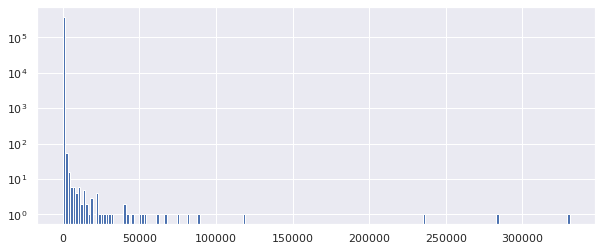

In [21]:
frc['fuel_cost_per_mmbtu'].hist(bins=200, log=True)

<AxesSubplot:>

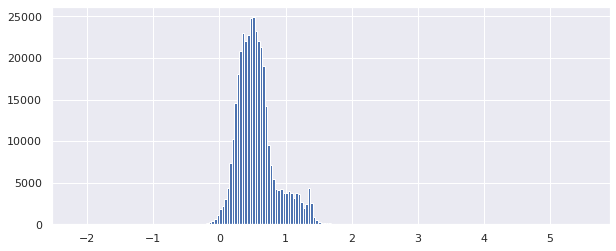

In [22]:
frc.loc[frc['fuel_cost_per_mmbtu'].gt(0), 'fuel_cost_per_mmbtu'].transform(np.log10).hist(bins=200, log=False)

<AxesSubplot:>

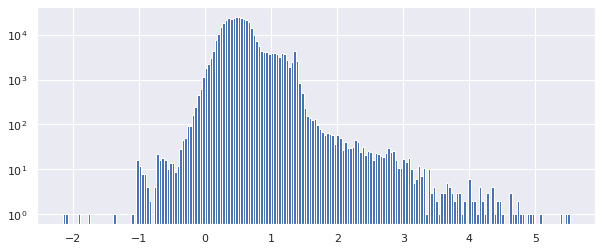

In [23]:
frc.loc[frc['fuel_cost_per_mmbtu'].gt(0), 'fuel_cost_per_mmbtu'].transform(np.log10).hist(bins=200, log=True)

In [24]:
frc['fuel_cost_per_mmbtu'].lt(0).agg(['mean', 'sum'])

mean     0.000033
sum     19.000000
Name: fuel_cost_per_mmbtu, dtype: float64

## Quick Test of an ML Model
Use the same features as the groupby model.

Notes:
* groupby model outperforms on training set but overfits and loses on test set

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
categorical_features = ['state', 'fuel_group_code', 'contract_type_code', 'primary_transportation_mode_code', 'energy_source_code']
numeric_features = ['report_date', 'fuel_received_units', 'latitude', 'longitude',]
target = ['fuel_cost_per_mmbtu']
no_nan = frc.loc[:, categorical_features + numeric_features + target].dropna(subset='fuel_cost_per_mmbtu')
no_nan.loc[:, categorical_features] = no_nan.loc[:, categorical_features].astype('category')

In [27]:
def convert_datetime_to_n_days_from_start(ser: pd.Series) -> pd.Series:
    # could generalize w/ df.select_dtypes('datetime')
    start = ser.min()
    delta = (ser - start).dt.days
    delta = pd.to_numeric(delta, downcast='integer') # for memory efficiency
    return delta

In [28]:
test = no_nan.sample(5)['report_date']
pd.concat([test, convert_datetime_to_n_days_from_start(test)], axis=1).dtypes

report_date    datetime64[ns]
report_date             int16
dtype: object

In [29]:
no_nan.loc[:, 'report_date'] = convert_datetime_to_n_days_from_start(no_nan.loc[:, 'report_date'])

In [30]:
no_nan.loc[:, target] = no_nan.loc[:, target].clip(upper=1000) # blunt ridiculous outliers

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='report_date', ylabel='[fuel_cost_per_mmbtu]'>

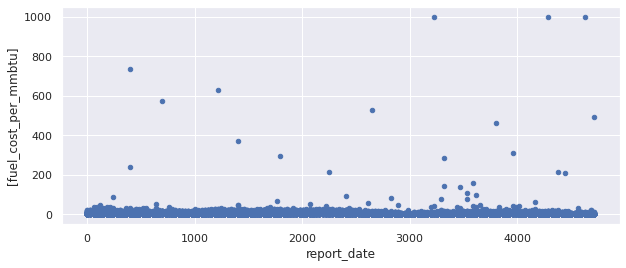

In [31]:
no_nan.sample(10_000).plot(x='report_date', y=target, kind='scatter')

In [32]:
# We don't actually want a row-wise random sample for real training, we want to emulate the missingness process (random whole plants?). But good enough for now.
x_train, x_test, y_train, y_test = train_test_split(no_nan[categorical_features + numeric_features],
                                                    no_nan[target],
                                                    test_size=0.3,
                                                    random_state=42
                                                   )

In [33]:
groupby_model = (pd.concat([x_train, y_train], axis=1)
                 .groupby(['state', 'report_date', 'fuel_group_code'],
                          as_index=False
                         )['fuel_cost_per_mmbtu']
                 .median()
                )

In [34]:
model = lgbm.LGBMRegressor(num_leaves=2**8,
                           max_depth=12,
                           learning_rate=0.1,
                           n_estimators=1000,
                           min_child_samples=15,
                           random_state=42,
                           first_metric_only=True,
                           boosting='gbdt',
                           objective='l1',
                          )

In [35]:
model.fit(x_train,
          y_train,
          eval_set=[(x_test, y_test), (x_train, y_train)],
          eval_names=['validation', 'training'],
          #categorical_feature=categorical_features,
          verbose=50,
          eval_metric='l1',
          early_stopping_rounds=10,
         )

/home/tpb/miniconda3/envs/lgbm_impute/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/tpb/miniconda3/envs/lgbm_impute/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/tpb/miniconda3/envs/lgbm_impute/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/tpb/miniconda3/envs/lgb

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	training's l1: 1.78365	validation's l1: 1.79051
[100]	training's l1: 1.65218	validation's l1: 1.68574
[150]	training's l1: 1.57648	validation's l1: 1.62802
[200]	training's l1: 1.48643	validation's l1: 1.54565
[250]	training's l1: 1.40271	validation's l1: 1.48966
[300]	training's l1: 1.38583	validation's l1: 1.47755
[350]	training's l1: 1.3697	validation's l1: 1.46743
[400]	training's l1: 1.36033	validation's l1: 1.46249
[450]	training's l1: 1.35039	validation's l1: 1.45702
[500]	training's l1: 1.31755	validation's l1: 1.44051
[550]	training's l1: 1.2798	validation's l1: 1.41517
[600]	training's l1: 1.25163	validation's l1: 1.40112


LGBMRegressor(boosting='gbdt', first_metric_only=True, max_depth=12,
              min_child_samples=15, n_estimators=1000, num_leaves=256,
              objective='l1', random_state=42)

In [36]:
model.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('l1', 1.2373425574994095)]),
             'validation': OrderedDict([('l1', 1.394570142169741)])})

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l1'>

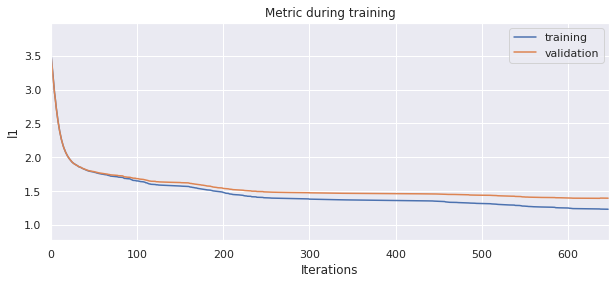

In [37]:
lgbm.plot_metric(model, metric='l1')

In [38]:
def error_comparison(x, y, model, groupby_df):
    preds = model.predict(x)
    error = pd.DataFrame({'predict': preds, 'error': preds - y.values.reshape(-1)}, index=y.index)
    error = pd.concat([error, x, y], axis=1)
    error['rel_error'] = error['error'].div(error['fuel_cost_per_mmbtu'])
    error = error.merge(groupby_df.rename(columns={'fuel_cost_per_mmbtu': 'groupby_predict'}), on=['state', 'report_date', 'fuel_group_code'])
    error['groupby_error'] = error['groupby_predict'].sub(error['fuel_cost_per_mmbtu'], axis=0)
    error['groupby_rel_error'] = error['groupby_error'].div(error['fuel_cost_per_mmbtu'], axis=0)
    error['model_diff'] = error['error'] - error['groupby_error']
    return error

In [39]:
error_tr = error_comparison(x_train, y_train, model, groupby_model)

In [40]:
error_test = error_comparison(x_test, y_test, model, groupby_model)

In [41]:
# train
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(error_tr.groupby('fuel_group_code')['error'].describe().T)

fuel_group_code,coal,natural_gas,other_gas,petroleum,petroleum_coke
count,102091.000,139089.000,164.000,19590.000,1044.000
mean,-0.020,-1.351,-1.915,0.092,-0.005
std,0.757,28.117,23.058,3.590,0.336
min,-30.943,-996.900,-294.269,-77.425,-2.281
25%,-0.091,-0.215,-0.201,-0.389,-0.062
50%,0.000,0.000,-0.000,0.001,0.001
75%,0.092,0.186,0.344,0.397,0.081
max,90.946,531.722,4.932,222.967,1.475


In [42]:
# test
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(error_test.groupby('fuel_group_code')['error'].describe().T)

fuel_group_code,coal,natural_gas,other_gas,petroleum,petroleum_coke
count,43701.000,59773.000,78.000,8189.000,454.000
mean,-0.005,-1.438,-0.010,0.040,-0.010
std,0.862,29.310,1.556,5.951,0.353
min,-11.009,-996.923,-8.745,-403.572,-1.809
25%,-0.114,-0.252,-0.480,-0.599,-0.117
50%,0.003,0.005,0.151,0.025,0.009
75%,0.119,0.236,0.751,0.623,0.149
max,59.701,717.549,4.017,157.678,1.070


In [43]:
# train
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(error_tr.groupby('fuel_group_code')['rel_error'].describe().T)

fuel_group_code,coal,natural_gas,other_gas,petroleum,petroleum_coke
count,102091.000,139089.000,164.000,19590.000,1044.000
mean,inf,0.027,0.036,NaN,0.041
std,NaN,1.054,0.280,NaN,0.234
min,-2.487,-36.146,-0.953,-inf,-0.663
25%,-0.039,-0.052,-0.022,-0.023,-0.035
50%,0.000,0.000,-0.000,0.000,0.001
75%,0.044,0.052,0.059,0.025,0.049
max,inf,189.386,2.126,inf,2.887


In [44]:
# test
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(error_test.groupby('fuel_group_code')['rel_error'].describe().T)

fuel_group_code,coal,natural_gas,other_gas,petroleum,petroleum_coke
count,43701.000,59773.000,78.000,8189.000,454.000
mean,inf,0.035,0.115,inf,0.038
std,NaN,1.583,0.415,NaN,0.213
min,-3.812,-117.696,-0.694,-2.569,-0.501
25%,-0.048,-0.061,-0.047,-0.034,-0.056
50%,0.001,0.001,0.016,0.002,0.006
75%,0.058,0.067,0.135,0.041,0.084
max,inf,233.169,1.992,inf,1.237


In [66]:
# test, for rows with successful groupby model
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(error_test.dropna(subset='groupby_predict').groupby('fuel_group_code')['rel_error'].describe().T)

fuel_group_code,coal,natural_gas,other_gas,petroleum,petroleum_coke
count,43507.000,59609.000,9.000,7669.000,323.000
mean,inf,0.034,0.012,inf,0.044
std,NaN,1.584,0.052,NaN,0.234
min,-3.812,-117.696,-0.052,-2.569,-0.501
25%,-0.048,-0.061,-0.007,-0.033,-0.058
50%,0.001,0.001,0.005,0.002,0.006
75%,0.058,0.067,0.016,0.040,0.094
max,inf,233.169,0.122,inf,1.237


In [45]:
# train, groupby
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(error_tr.groupby('fuel_group_code')['groupby_rel_error'].describe().T)

fuel_group_code,coal,natural_gas,other_gas,petroleum,petroleum_coke
count,102091.000,139089.000,164.000,19587.000,1044.000
mean,inf,0.012,0.001,inf,0.040
std,NaN,0.920,0.017,NaN,0.253
min,-0.948,-34.897,-0.075,-0.843,-0.613
25%,-0.104,-0.091,0.000,-0.027,-0.007
50%,0.000,0.000,0.000,0.000,0.000
75%,0.116,0.078,0.000,0.026,0.009
max,inf,222.625,0.088,inf,2.557


In [46]:
# test, groupby
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(error_test.groupby('fuel_group_code')['groupby_rel_error'].describe().T)

fuel_group_code,coal,natural_gas,other_gas,petroleum,petroleum_coke
count,43507.000,59609.000,9.000,7669.000,323.000
mean,inf,0.036,0.169,inf,0.075
std,NaN,1.880,0.379,NaN,0.456
min,-0.832,-49.100,-0.133,-1.000,-0.623
25%,-0.113,-0.101,0.000,-0.047,-0.104
50%,0.001,0.000,0.071,-0.000,-0.002
75%,0.132,0.089,0.154,0.050,0.127
max,inf,270.429,1.150,inf,3.020


In [47]:
is_gas = error_test['fuel_group_code'].eq('natural_gas')
is_gas.mean()

0.532759926912964

<AxesSubplot:>

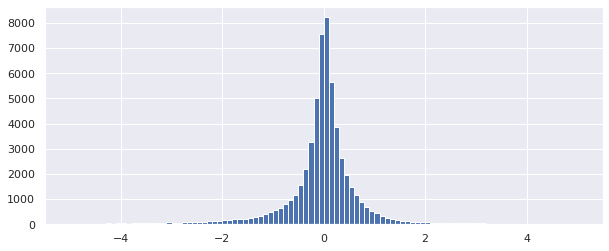

In [48]:
error_test.loc[is_gas, 'error'].hist(bins=100, range=(-5,5), log=False)

<AxesSubplot:>

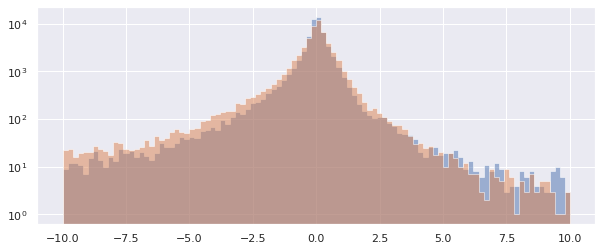

In [49]:
error_test.loc[is_gas, 'error'].hist(bins=100, range=(-10,10), log=True, histtype='stepfilled', alpha=0.5, label='lgbm')
error_test.loc[is_gas, 'groupby_error'].hist(bins=100, range=(-10,10), log=True, histtype='stepfilled', alpha=0.5, label='groupby')

<AxesSubplot:>

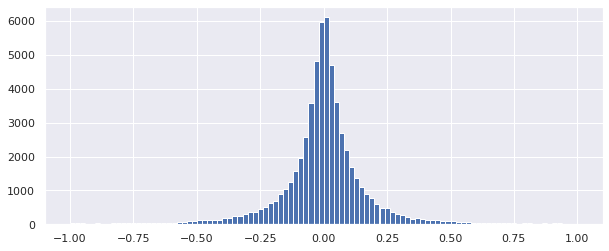

In [50]:
error_test.loc[is_gas, 'rel_error'].hist(bins=100, range=(-1,1), log=False)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='fuel_cost_per_mmbtu', ylabel='error'>

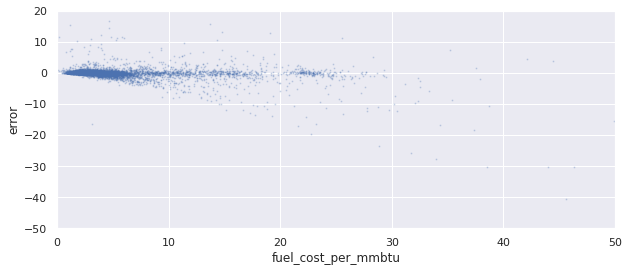

In [51]:
error_test.sample(10_000).plot.scatter('fuel_cost_per_mmbtu', 'error', s=1, alpha=0.2,
                                     xlim=(0,50), ylim=(-50, 20)
                                    )

In [52]:
error_test.loc[error_test['error'].abs().nlargest(20).index,:]

,predict,error,state,fuel_group_code,contract_type_code,primary_transportation_mode_code,energy_source_code,report_date,fuel_received_units,latitude,longitude,fuel_cost_per_mmbtu,rel_error,groupby_predict,groupby_error,groupby_rel_error,model_diff
22452,3.077363,-996.922637,IN,natural_gas,S,PL,NG,4627,350.0,41.720800,-86.90860,1000.0,-0.996923,2.0200,-997.9800,-0.997980,1.057363
21331,3.359446,-996.640554,LA,natural_gas,S,PL,NG,3013,161.0,32.706100,-92.06830,1000.0,-0.996641,2.2455,-997.7545,-0.997754,1.113946
19719,3.541933,-996.458067,MS,natural_gas,S,PL,NG,3319,822.0,30.439200,-89.02860,1000.0,-0.996458,3.2300,-996.7700,-0.996770,0.311933
66687,4.593893,-995.406107,CA,natural_gas,S,PL,NG,4138,5.0,34.155600,-118.27820,1000.0,-0.995406,3.2130,-996.7870,-0.996787,1.380893
66336,4.714967,-995.285033,ND,natural_gas,C,PL,NG,4627,5.0,46.866900,-100.88360,1000.0,-0.995285,2.9160,-997.0840,-0.997084,1.798967
38663,4.884674,-995.115326,CA,natural_gas,S,PL,NG,3987,8.0,34.155600,-118.27820,1000.0,-0.995115,5.8660,-994.1340,-0.994134,-0.981326
75587,4.916225,-995.083775,LA,natural_gas,S,PL,NG,2496,80.0,32.706100,-92.06830,1000.0,-0.995084,4.3740,-995.6260,-0.995626,0.542225
97176,5.014687,-994.985313,OH,natural_gas,S,PL,NG,1339,801.0,39.713900,-83.17780,1000.0,-0.994985,4.2560,-995.7440,-0.995744,0.758687
75589,5.541849,-994.458151,LA,natural_gas,S,PL,NG,2496,285.0,32.706100,-92.06830,1000.0,-0.994458,4.3740,-995.6260,-0.995626,1.167849
64889,6.155057,-993.844943,OK,natural_gas,S,PL,NG,4352,23.0,35.469880,-97.67498,1000.0,-0.993845,2.0160,-997.9840,-0.997984,4.139057


In [53]:
import shap

In [54]:
explainer = shap.TreeExplainer(model)

In [59]:
%%time
sample = x_test.sample(1_000)
shap_values = explainer.shap_values(sample)

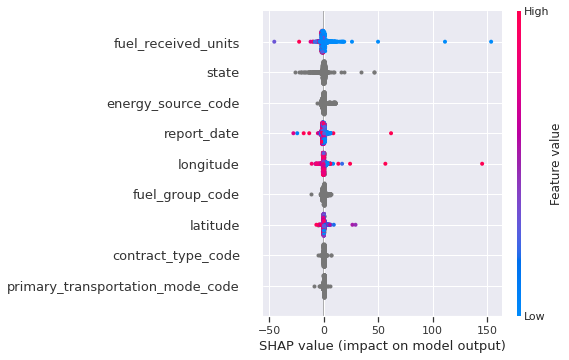

In [65]:
shap.summary_plot(shap_values, sample)